# Chapter 28: Lyric Searching

Lyrics can be difficult to search through for various reasons.

In [1]:
from music21 import *

Let’s start by taking a piece that will be a good example.

In [2]:
luca = corpus.parse('luca/gloria')
cantus = luca.parts[0]
cantus.measures(1, 6).show('xml')

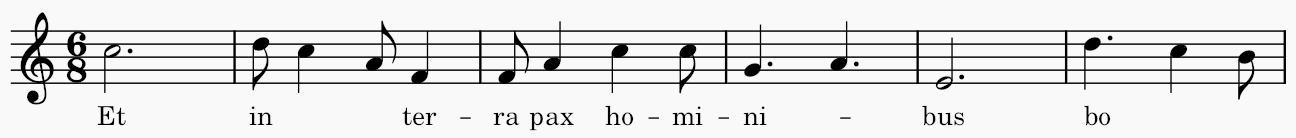

This code is unlikely to work

In [3]:
dominePS = None
for n in cantus.recurse().getElementsByClass('Note'):
    if n.lyric == 'Domine':
        dominePS = n.pitch.ps

Did we get anything ?

In [4]:
print(dominePS)

None


Why? Because “domine” is **three syllables long**. Thus, it is not going to be found on a single note.

But you can  check to see if “Domine” appears in the piece at all using the ***music21.text.assembleLyrics()*** function

In [5]:
allText = text.assembleLyrics(cantus)
if 'Domine' in allText:
    print("Yup!")

Yup!


***music21.search.lyrics.LyricSearcher*** will rescue you to get closer to figure oout what pitches are used by "Domine"

In [6]:
ls = search.lyrics.LyricSearcher(cantus)

Now let’s search for “Domine”:

In [7]:
domineResults = ls.search("Domine")

How many times did it appear?

In [8]:
len(domineResults)

3

Let’s look more closely at the results to see where:

In [10]:
domineResults

[SearchMatch(mStart=28, mEnd=29, matchText='Domine', els=(<music21.note.Note C>, <music21.note.Note A>, <music21.note.Note F>), indices=[...], identifier=1),
 SearchMatch(mStart=38, mEnd=39, matchText='Domine', els=(<music21.note.Note C>, <music21.note.Note A>, <music21.note.Note B>), indices=[...], identifier=1),
 SearchMatch(mStart=48, mEnd=48, matchText='Domine', els=(<music21.note.Note A>, <music21.note.Note B>, <music21.note.Note C>), indices=[...], identifier=1)]

*(identifier=1)* means that they are part of the first lyrics of the text 

In [11]:
cantus.measures(24, 48).show('xml')

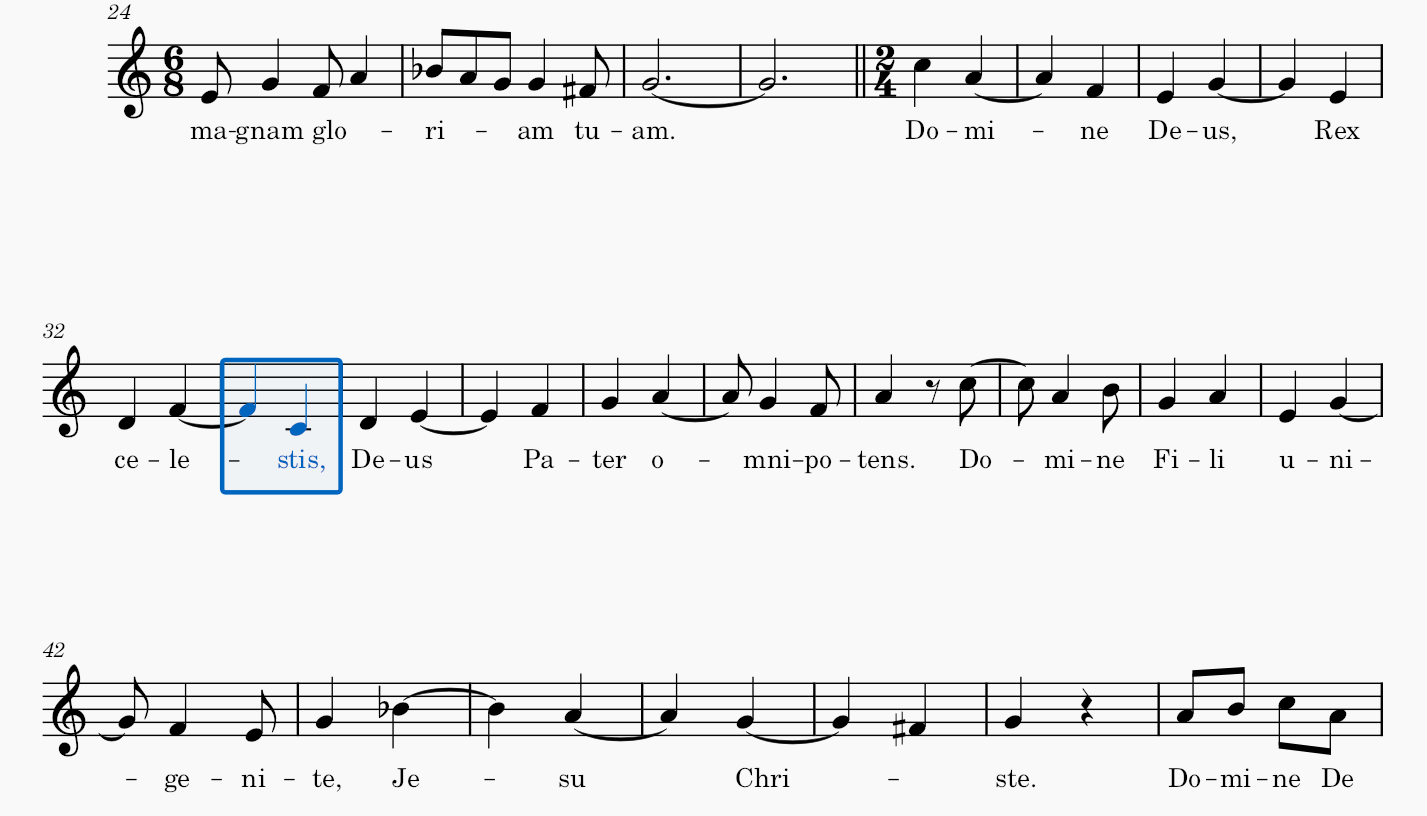

There’s something interesting in that all three times the word follows a **double-bar or rest**.

Clearly it’s an **important word at an important place** in the sentence.

In [12]:
# Let’s look at the first SearchMatch object in some detail
sm0 = domineResults[0]
sm0.mStart, sm0.mEnd

(28, 29)

It knows which notes **contained the syllables** making up “Domine”

In [14]:
sm0.els

(<music21.note.Note C>, <music21.note.Note A>, <music21.note.Note F>)

Notice that the second “A” (after the **tie**) is not included in the search results

For instance, take “**ri**am tuam.” found at the beginning.

In [15]:
smGloriam = ls.search('iam tuam.')
smGloriam[0].els

(<music21.note.Note B->,
 <music21.note.Note G>,
 <music21.note.Note F#>,
 <music21.note.Note G>)

There are three notes on “ri” (B-flat, A, G) but **only the B-flat** will be included in this search

Future work should make it possible to return the intermediate notes or rests in between, etc.

In [16]:
# For now you could do something like this instead
firstNote = smGloriam[0].els[0]
lastNote = smGloriam[0].els[-1]

allRelevantNotes = [firstNote]
currentNote = firstNote

while currentNote is not None:
    currentNote = currentNote.next('Note')
    allRelevantNotes.append(currentNote)
    if currentNote is lastNote:
        break

allRelevantNotes

[<music21.note.Note B->,
 <music21.note.Note A>,
 <music21.note.Note G>,
 <music21.note.Note G>,
 <music21.note.Note F#>,
 <music21.note.Note G>]

!!! 注意由于*SearchMatch* 模块的局限性，导致无法显示带有连音记号的所有音符，因此我们需要人为的改善这一缺陷，即上述算法遍历所有与歌词相关的音符序列，存储到*allRelevantNotes*数组中

let’s get back to the Domine pitch question

In [26]:
# It has a .matchText attribute
sm0.matchText

'Domine'

Well, that’s pretty useless here. But you can pass in **regular expressions**

In [27]:
# Let's find the word with vowel combination that o followed by i, with one letter in between
# re 处理正则表达式
import re
reSearchVowels = re.compile(r'\w+o\wi\w+', re.IGNORECASE)
foundVowels = ls.search(reSearchVowels)
len(foundVowels)

11

***.matchText*** knows what it matched

In [28]:
[result.matchText for result in foundVowels]

['hominibus',
 'Glorificamus',
 'gloriam',
 'Domine',
 'Domine',
 'Domine',
 'nobis',
 'nobis',
 'Quoniam',
 'Dominus',
 'gloria']

Let’s get back to ：is “Domine” higher than average?

In [30]:
domineResults

[SearchMatch(mStart=28, mEnd=29, matchText='Domine', els=(<music21.note.Note C>, <music21.note.Note A>, <music21.note.Note F>), indices=[...], identifier=1),
 SearchMatch(mStart=38, mEnd=39, matchText='Domine', els=(<music21.note.Note C>, <music21.note.Note A>, <music21.note.Note B>), indices=[...], identifier=1),
 SearchMatch(mStart=48, mEnd=48, matchText='Domine', els=(<music21.note.Note A>, <music21.note.Note B>, <music21.note.Note C>), indices=[...], identifier=1)]

In [29]:
# We’ll look at the average .ps or pitch space (MIDI number) for the pitches
dominePitchPSes = []
for thisMatch in domineResults:
    for thisNote in thisMatch.els:
        dominePitchPSes.append(thisNote.pitch.ps)

dominePitchPSes

[72.0, 69.0, 65.0, 72.0, 69.0, 71.0, 69.0, 71.0, 72.0]

Python gives us a nice set of functions for the **mean and median**

In [31]:
from statistics import mean, median

mean(dominePitchPSes), median(dominePitchPSes)

(70.0, 71.0)

And for the piece as a whole?

In [33]:
allPitchPSes = []
for thisNote in cantus.recurse().getElementsByClass('Note'):
    allPitchPSes.append(thisNote.pitch.ps)

mean(allPitchPSes), median(allPitchPSes)

(67.41100323624596, 67.0)

Is this statistically significant? We’ll need to perform more tests to be sure! 